# Feature Engineering for Credit Risk Score

## Initial steps

Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

Reproducibility and display

In [2]:
np.random.seed(42)
pd.options.display.max_columns = 200
sns.set_palette('Set2')

Load data

In [3]:
df = pd.read_csv('../data/credit_risk_cleaned.csv')
print('Loaded dataset shape:', df.shape)
df.head()

Loaded dataset shape: (31679, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,0
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,1
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2,1
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,1
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,0.25,N,2,1


## Derived Features

Create derived features to improve model performance. We can start by creating a new features based on existent ones. We will create the "loan_to_income" ratio that can be related to the target column and "employ_to_age" ratio that shows the job stability of the borrower.

In [4]:
df_fe = df.copy()
df_fe['loan_to_income'] = df_fe['loan_amnt'] / (df_fe['person_income'].replace(0, np.nan))
df_fe['employ_to_age'] = df_fe['person_emp_length'] / (df_fe['person_age'].replace(0, np.nan))

We make "buckets" for the person_age and person_emp_length to reuce the ammount of options in these variables

In [5]:
df_fe['age_bucket'] = pd.cut(df_fe['person_age'], bins=[18,25,35,45,55,65,120], labels=['18-24','25-34','35-44','45-54','55-64','65+'])

df_fe['emp_length_bin'] = pd.cut(df_fe['person_emp_length'].fillna(0), bins=[-1,0,1,3,5,10,100], labels=['0','1','2-3','4-5','6-10','10+'])

Binary encoding for the cb_person_default_on_file

In [6]:
df_fe['default_flag'] = df_fe['cb_person_default_on_file'].map({'Y':1,'N':0}).fillna(0).astype(int)

Print new features

In [7]:
print('New features created:', df_fe.shape[1] - df.shape[1])
print('New columns:', [c for c in df_fe.columns if c not in df.columns])

New features created: 5
New columns: ['loan_to_income', 'employ_to_age', 'age_bucket', 'emp_length_bin', 'default_flag']


## Preprocessing pipeline

We split the dataset into numeric and categorical features

In [8]:
# Numeric cols exclude target
numeric_cols = df_fe.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('loan_status')

# Categorical cols
cat_cols = df_fe.select_dtypes(include=['object','category']).columns.tolist()

print(f'Numeric features ({len(numeric_cols)}): {numeric_cols[:10]}')
print(f'Categorical features ({len(cat_cols)}): {cat_cols}')

Numeric features (10): ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_to_income', 'employ_to_age', 'default_flag']
Categorical features (6): ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file', 'age_bucket', 'emp_length_bin']


We use a `ColumnTransformer` to standardize numeric features and one-hot encode categorical features.

In [9]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_cols),
    ('cat', cat_pipeline, cat_cols)
], remainder='drop')

Fit preprocessor using the entire dataset.

In [10]:
X = df_fe.drop(columns=['loan_status'])
y = df_fe['loan_status']

X_trans = preprocessor.fit_transform(X)

num_features = numeric_cols
cat_ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
cat_features = cat_ohe.get_feature_names_out(cat_cols).tolist()

all_features = list(num_features) + list(cat_features)
X_trans_df = pd.DataFrame(X_trans, columns=all_features)

print(f'Transformed dataset shape: {X_trans_df.shape}')
print(f'Total features: {len(all_features)}')
X_trans_df.head()

Transformed dataset shape: (31679, 41)
Total features: 41


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_to_income,employ_to_age,default_flag,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y,age_bucket_18-24,age_bucket_25-34,age_bucket_35-44,age_bucket_45-54,age_bucket_55-64,age_bucket_65+,emp_length_bin_0,emp_length_bin_1,emp_length_bin_10+,emp_length_bin_2-3,emp_length_bin_4-5,emp_length_bin_6-10
0,-1.083264,-1.078118,0.054013,-1.367162,0.034226,-0.655048,-0.938311,-0.617606,0.473413,-0.464799,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.439486,-1.078118,-0.937341,-0.656740,0.597715,3.767765,-0.691984,3.781984,-0.991252,-0.464799,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.761375,-0.018763,-0.193826,4.000473,1.366405,3.391355,-0.938311,3.420016,-0.001134,-0.464799,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.600431,-0.229118,0.797529,4.000473,1.053718,3.579560,-0.445657,4.443360,1.177579,2.151469,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.083264,-1.072433,-0.689503,-1.130355,-1.268639,0.756488,-0.938311,0.774857,-0.582836,-0.464799,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Feature selction

As we now have 40 features we will try to reduce that number, discarding those that don't contribute.

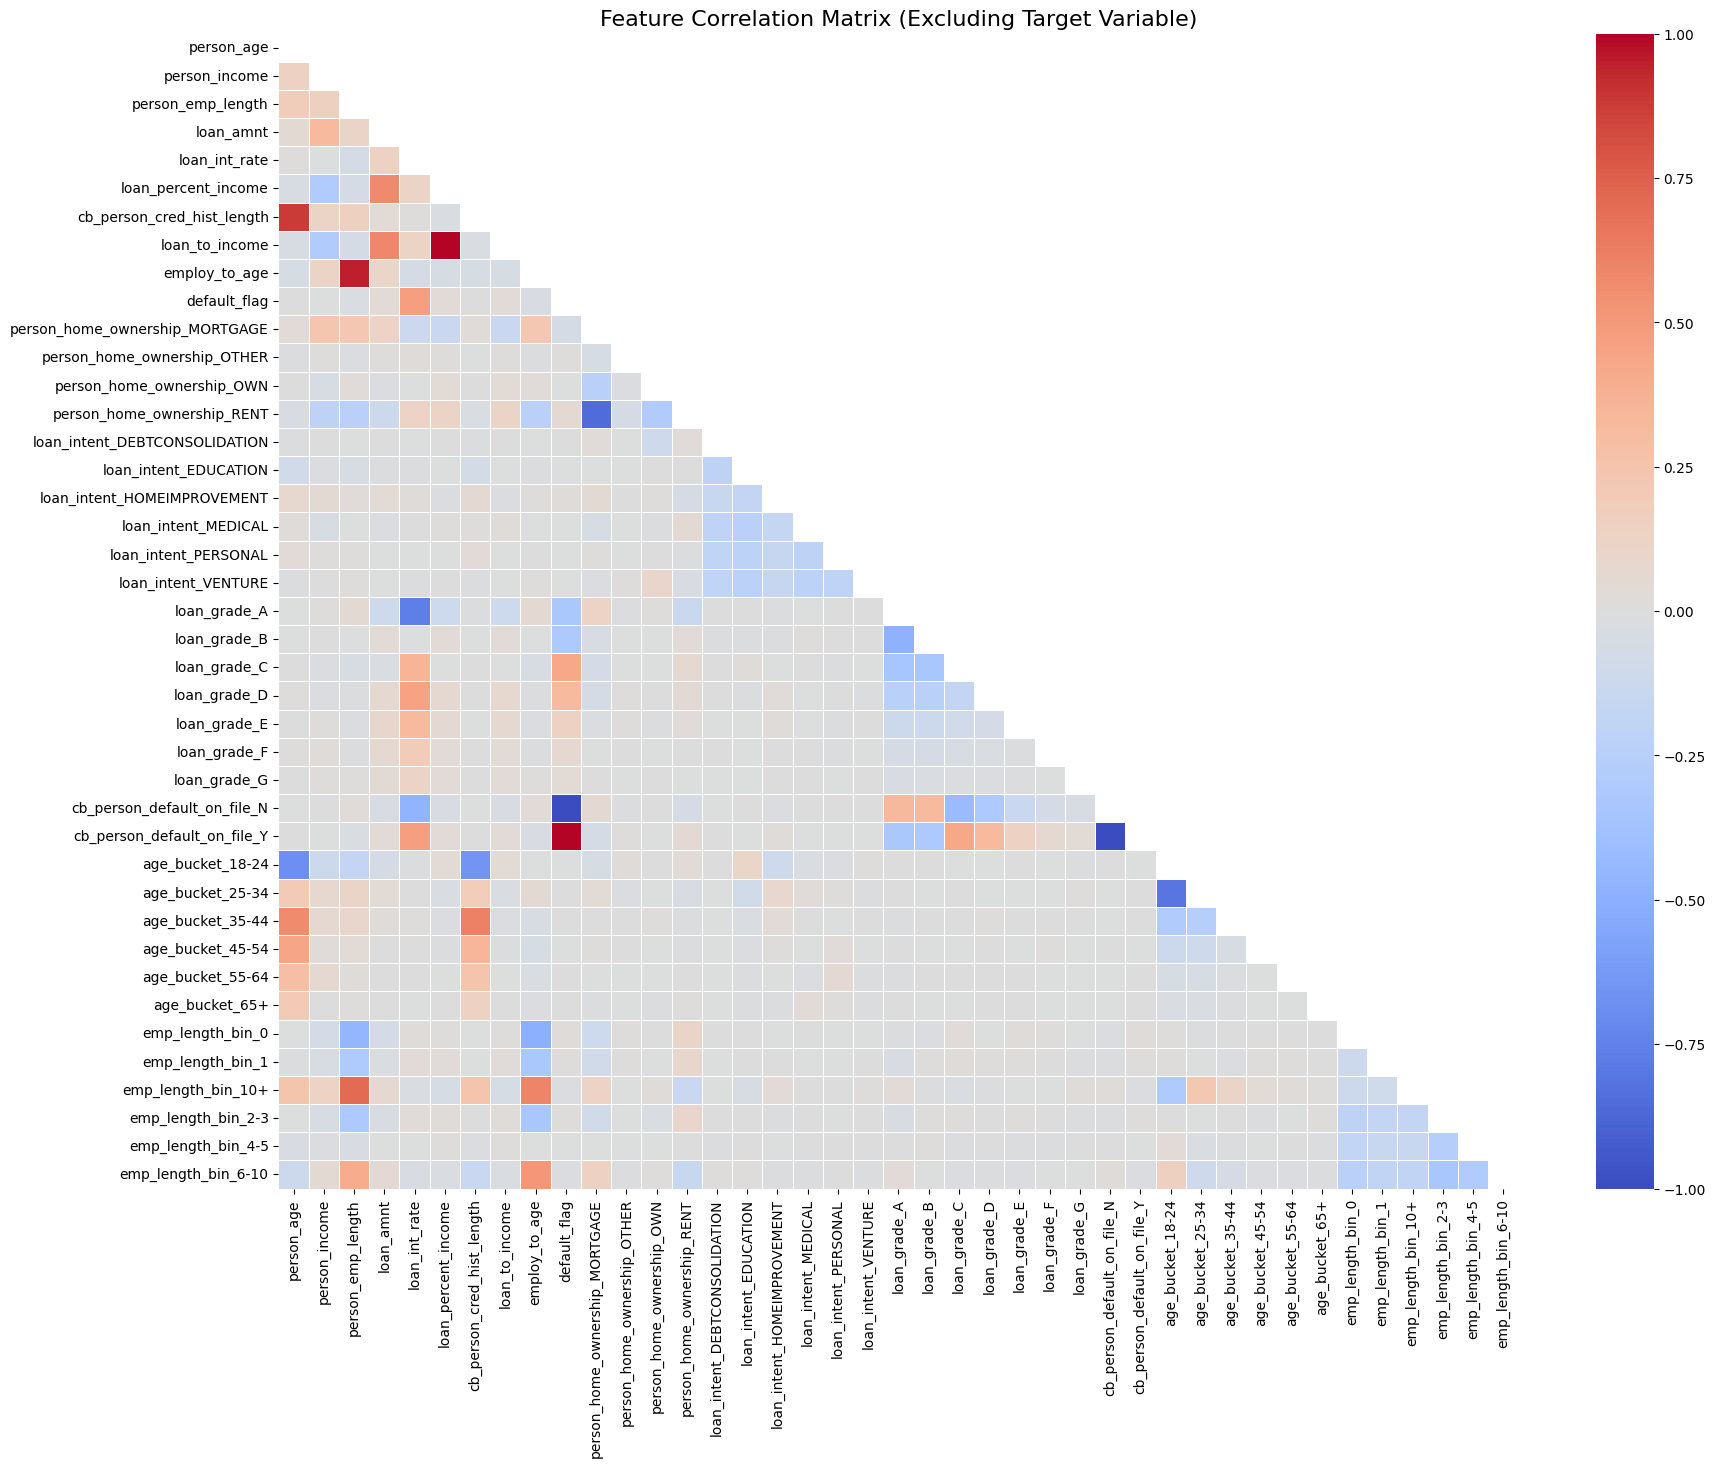

In [11]:
corr_matrix = X_trans_df.corr()

# Select upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, 
            mask=mask, 
            annot=False,
            cmap='coolwarm', 
            fmt=".2f", 
            linewidths=0.5)

plt.title('Feature Correlation Matrix (Excluding Target Variable)', fontsize=16)
plt.show()

Too many features to visualize clearly proceding to feature selection

### Elimination by correlation

To reuce the number of features we identify pairs with a correlation over 0.85 and eliminate the one with the least correlation with the target variable.

In [12]:
corr_matrix = X_trans_df.corr().abs()

# Select upper triangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns with correlation > 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

X_trans_reduced_df = X_trans_df.drop(columns=to_drop)

X_trans_reduced_df.shape[1]

35

We reduced the number of features to 35

### Elimination by importance

We can continue eliminating the variables that are not important for the prediction using `RandomForest`

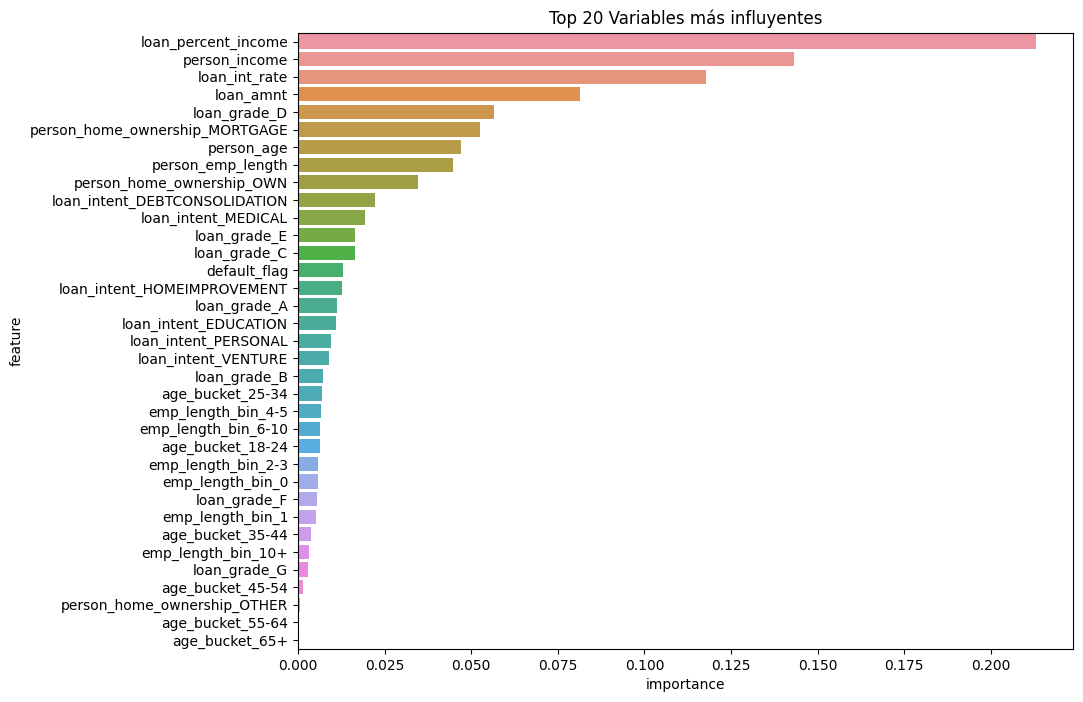

In [13]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_trans_reduced_df, y)

importances = pd.DataFrame({'feature': X_trans_reduced_df.columns, 'importance': rf.feature_importances_})
importances = importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importances)
plt.title('Top 20 Variables más influyentes')
plt.show()

As we can see the first variables are really relevant on the prediction while the lower ones are almost irrelevant so we will remove the ones with an "importance" lower than 0.01.

In [14]:
threshold = 0.01
# Features to keep
selected_features = importances[importances['importance'] >= threshold]['feature'].tolist()

X_trans_reduced_df = X_trans_reduced_df[selected_features]

X_trans_reduced_df.shape[1]

17

We reduced the numer of features to 17

### Elimination by low variance

Features that have the same value for almost all entries are useless for the model

In [15]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01) # Elimina variables donde el 99% es igual
selector.fit(X_trans_reduced_df)
features_to_keep = X_trans_reduced_df.columns[selector.get_support()]

X_trans_reduced_df = X_trans_reduced_df[features_to_keep]

X_trans_reduced_df.shape[1]

17

We didnt get to reduce it any further.

## Save transformed dataset and preprocessor

Save the fitted `preprocessor`, the feature names, and the transformed dataset to `../models` and `../data` so modeling can be done separately.

In [16]:
all_features = X_trans_reduced_df.columns.tolist()
all_features

['loan_percent_income',
 'person_income',
 'loan_int_rate',
 'loan_amnt',
 'loan_grade_D',
 'person_home_ownership_MORTGAGE',
 'person_age',
 'person_emp_length',
 'person_home_ownership_OWN',
 'loan_intent_DEBTCONSOLIDATION',
 'loan_intent_MEDICAL',
 'loan_grade_E',
 'loan_grade_C',
 'default_flag',
 'loan_intent_HOMEIMPROVEMENT',
 'loan_grade_A',
 'loan_intent_EDUCATION']

In [17]:
# Save fitted preprocessor and feature names
joblib.dump(preprocessor, '../models/preprocessor.joblib')
joblib.dump(all_features, '../models/feature_names.joblib')

# Attach target and save transformed dataset
X_trans_reduced_df['loan_status'] = y.values
X_trans_reduced_df.to_csv('../data/credit_risk_fe.csv', index=False)

## Summary

**Actions performed (in order):**
1. Created derived features.
2. Binned `person_age` into `age_bucket` and `person_emp_length` into `emp_length_bin`.
3. Encoded `cb_person_default_on_file` as binary `default_flag`.
4. Built preprocessing pipelines: numeric StandardScaler and categorical OneHotEncoder.
5. Fitted the `preprocessor` on the full feature set and transformed `X` to `X_trans_df`.
6. Produced the reduced feature matrix `X_trans_reduced_df` aplying correlation, importance-based and low-variance filters.
7. Saved the results.